# Nuages de mots

## Imports et stopwords

In [45]:
import os
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import pandas as pd

In [46]:
# Téléchargement des ressources NLTK si nécessaire
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/ilaria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilaria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
# stopwords français
sw = set(stopwords.words('french'))

In [49]:
# Stopwords OCR + bruit journalistique
sw |= {
    "bruxelles", "brux", "rue", "tél", "tel", "adresse",
    "soir", "matin", "jour", "hier", "demain",
    "prix", "vente", "achat", "maison",
    "samedi", "dimanche", "lundi", "mardi",
    "mercredi", "jeudi", "vendredi",
    "rossel", "belga", "afp",
    "hmu", "xix", "xii", "xxe", "xxx"
}

# Stopwords hors-thématique (évite les nuages inutiles)
sw |= {
    "film", "théâtre", "cinéma", "concert",
    "halloween", "costume",
    "ville", "place", "travail"
}


In [50]:
def nettoyer_texte(text):
    text = re.sub(r'[^\w\s\-àâäéèêëîïôöùûüç]', ' ', text)
    text = text.lower()
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\b\w{1,2}\b', ' ', text)     # Supprime les mots très courts
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [51]:
#charger les données 
data_path = "../../data/txt_tp4"
files = [f for f in os.listdir(data_path) if f.endswith(".txt")]
print("Nombre de fichiers thématiques =", len(files))


Nombre de fichiers thématiques = 999


In [53]:
# Fonction pour extraire l'année de chaque ficher
def extract_year(filename):
    """
    Extrait l'année d'un fichier CAMille format :
    KB_JB838_1966-08-03_01-00008.txt
    """
    parts = filename.split("_")
    for part in parts:
        if re.match(r"(19|20)\d{2}-\d{2}-\d{2}", part):
            return int(part[:4])
    return None


### Créer un texte global pour générer le nuage

In [54]:
corpus = []
corpus_decennies = {}

for f in files:
    year = extract_year(f)
    if year is None:
        print(" Année introuvable dans :", f)
        continue
    
    dec = (year // 10) * 10  # ex : 1966 → 1960

    with open(os.path.join(data_path, f), "r", encoding="utf-8") as ff:
        text = nettoyer_texte(ff.read())
    
    words = [w for w in text.split() if w not in sw]
    
    # Corpus global
    corpus.extend(words)
    
    # Corpus par décennie
    corpus_decennies.setdefault(dec, [])
    corpus_decennies[dec].append(" ".join(words))

print("Décennies disponibles :", sorted(corpus_decennies.keys()))
print("Nombre de mots corpus global :", len(corpus))


 Année introuvable dans : _README.txt
Décennies disponibles : [1950, 1960, 1970]
Nombre de mots corpus global : 2797829


### Nouage de points globale

[('-', 82740), ('plus', 14436), ('cette', 8007), ('musique', 7773), ('tout', 7265), ('deux', 6153), ('ena', 6124), ('comme', 6042), ('sans', 5970), ('bien', 5745), ('tous', 5282), ('grand', 4883), ('fait', 4738), ('programme', 4725), ('heures', 4626), ('après', 4410), ('van', 4381), ('dont', 4364), ('être', 4306), ('très', 4258), ('non', 4023), ('aussi', 3730), ('ans', 3711), ('sous', 3681), ('france', 3562), ('encore', 3407), ('monde', 3355), ('faire', 3199), ('cours', 3185), ('trois', 3179)]


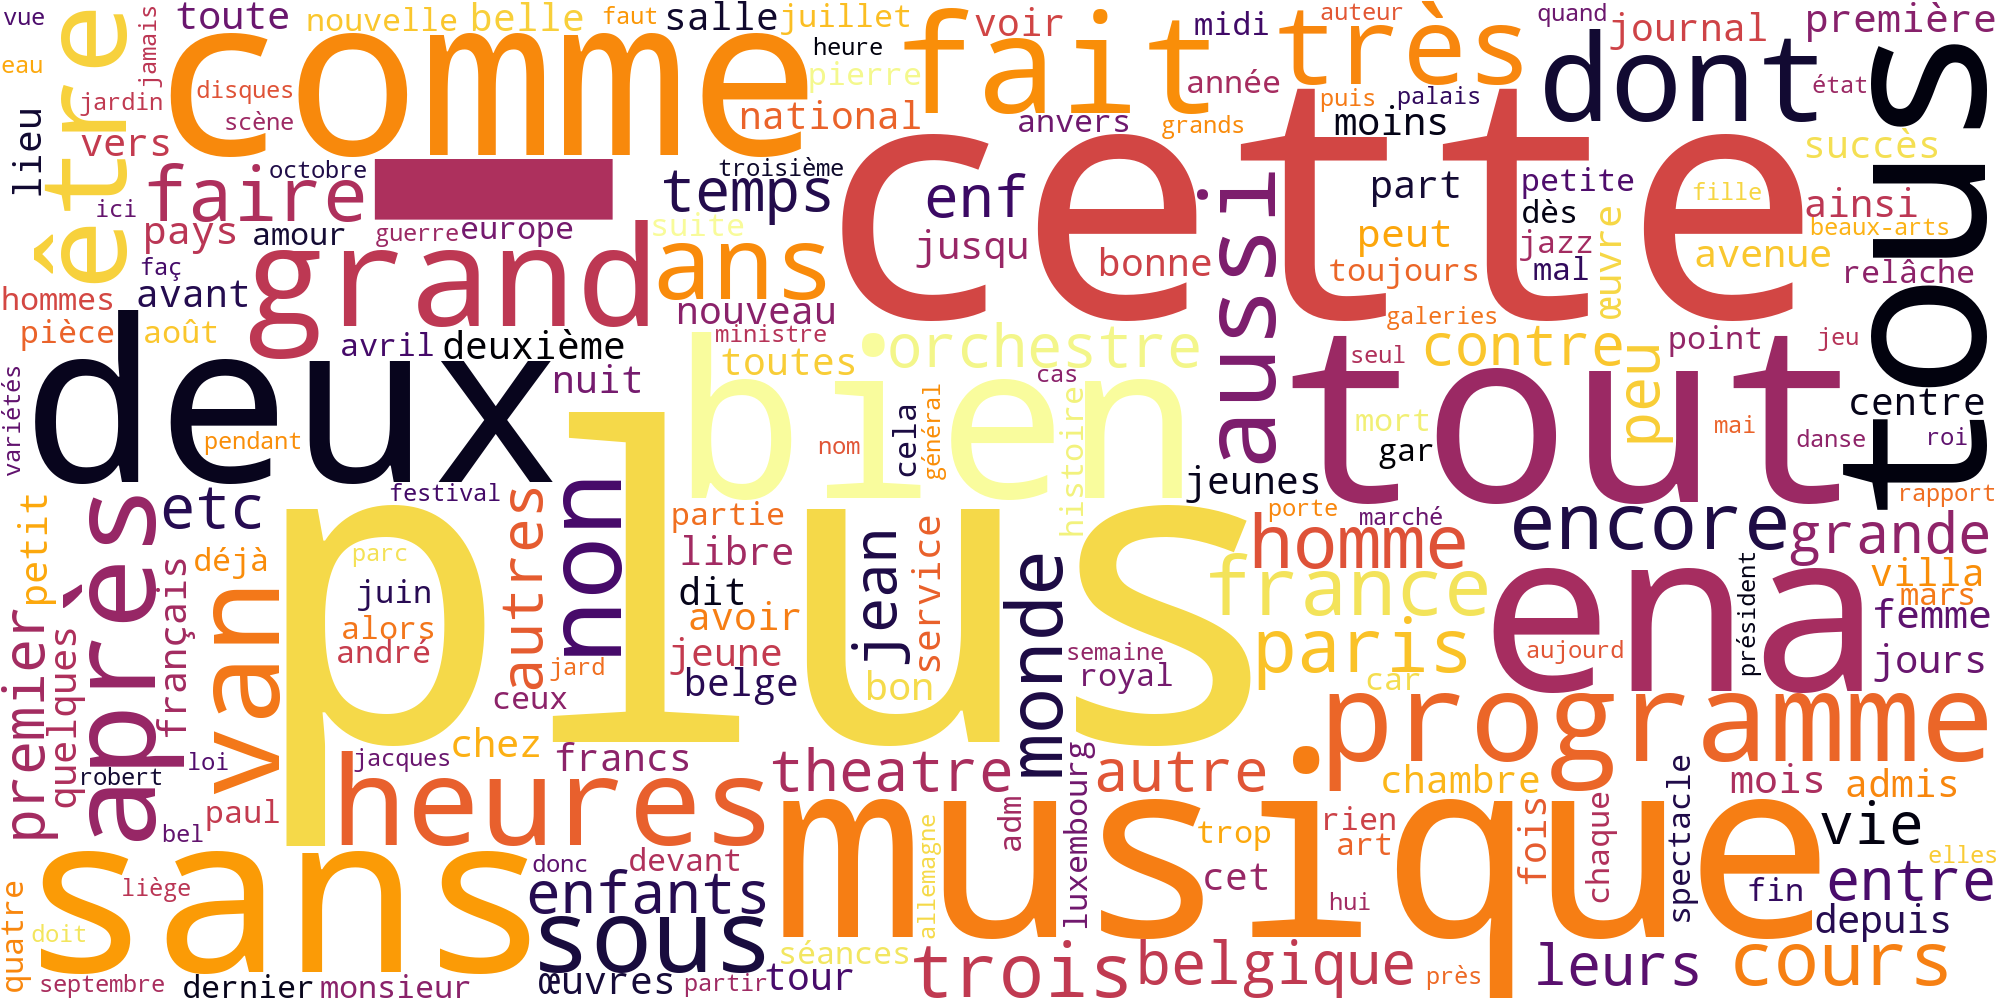

In [57]:
frequencies = Counter(corpus)

# Vérification des mots les plus fréquents
print(frequencies.most_common(30))

# Générer le nuage
cloud = WordCloud(
    width=2000, height=1000,
    background_color='white',
    colormap='inferno'
).generate_from_frequencies(frequencies)

# Sauvegarder et afficher
cloud.to_file("nuage_global.png")
from IPython.display import Image
Image("nuage_global.png")


### Nouage de points par décennie

In [58]:
for dec, textes in corpus_decennies.items():
    # Fusionner tous les textes de la décennie
    text_dec = " ".join(textes)
    freq_dec = Counter(text_dec.split())
    
    cloud_dec = WordCloud(
        width=2000, height=1000,
        background_color='white',
        colormap='magma'
    ).generate_from_frequencies(freq_dec)
    
    file_name = f"nuage_{dec}s.png"
    cloud_dec.to_file(file_name)
    print(f"Nuage décennie {dec}s généré -> {file_name}")


Nuage décennie 1960s généré -> nuage_1960s.png
Nuage décennie 1970s généré -> nuage_1970s.png
Nuage décennie 1950s généré -> nuage_1950s.png


### Construire les fréquences et le nuage de mots thématique

In [55]:
frequencies = Counter(corpus)

# Vérif : afficher les 30 mots les plus fréquents
frequencies.most_common(30)


[('-', 82740),
 ('plus', 14436),
 ('cette', 8007),
 ('musique', 7773),
 ('tout', 7265),
 ('deux', 6153),
 ('ena', 6124),
 ('comme', 6042),
 ('sans', 5970),
 ('bien', 5745),
 ('tous', 5282),
 ('grand', 4883),
 ('fait', 4738),
 ('programme', 4725),
 ('heures', 4626),
 ('après', 4410),
 ('van', 4381),
 ('dont', 4364),
 ('être', 4306),
 ('très', 4258),
 ('non', 4023),
 ('aussi', 3730),
 ('ans', 3711),
 ('sous', 3681),
 ('france', 3562),
 ('encore', 3407),
 ('monde', 3355),
 ('faire', 3199),
 ('cours', 3185),
 ('trois', 3179)]

### Générer et afficher le nuage

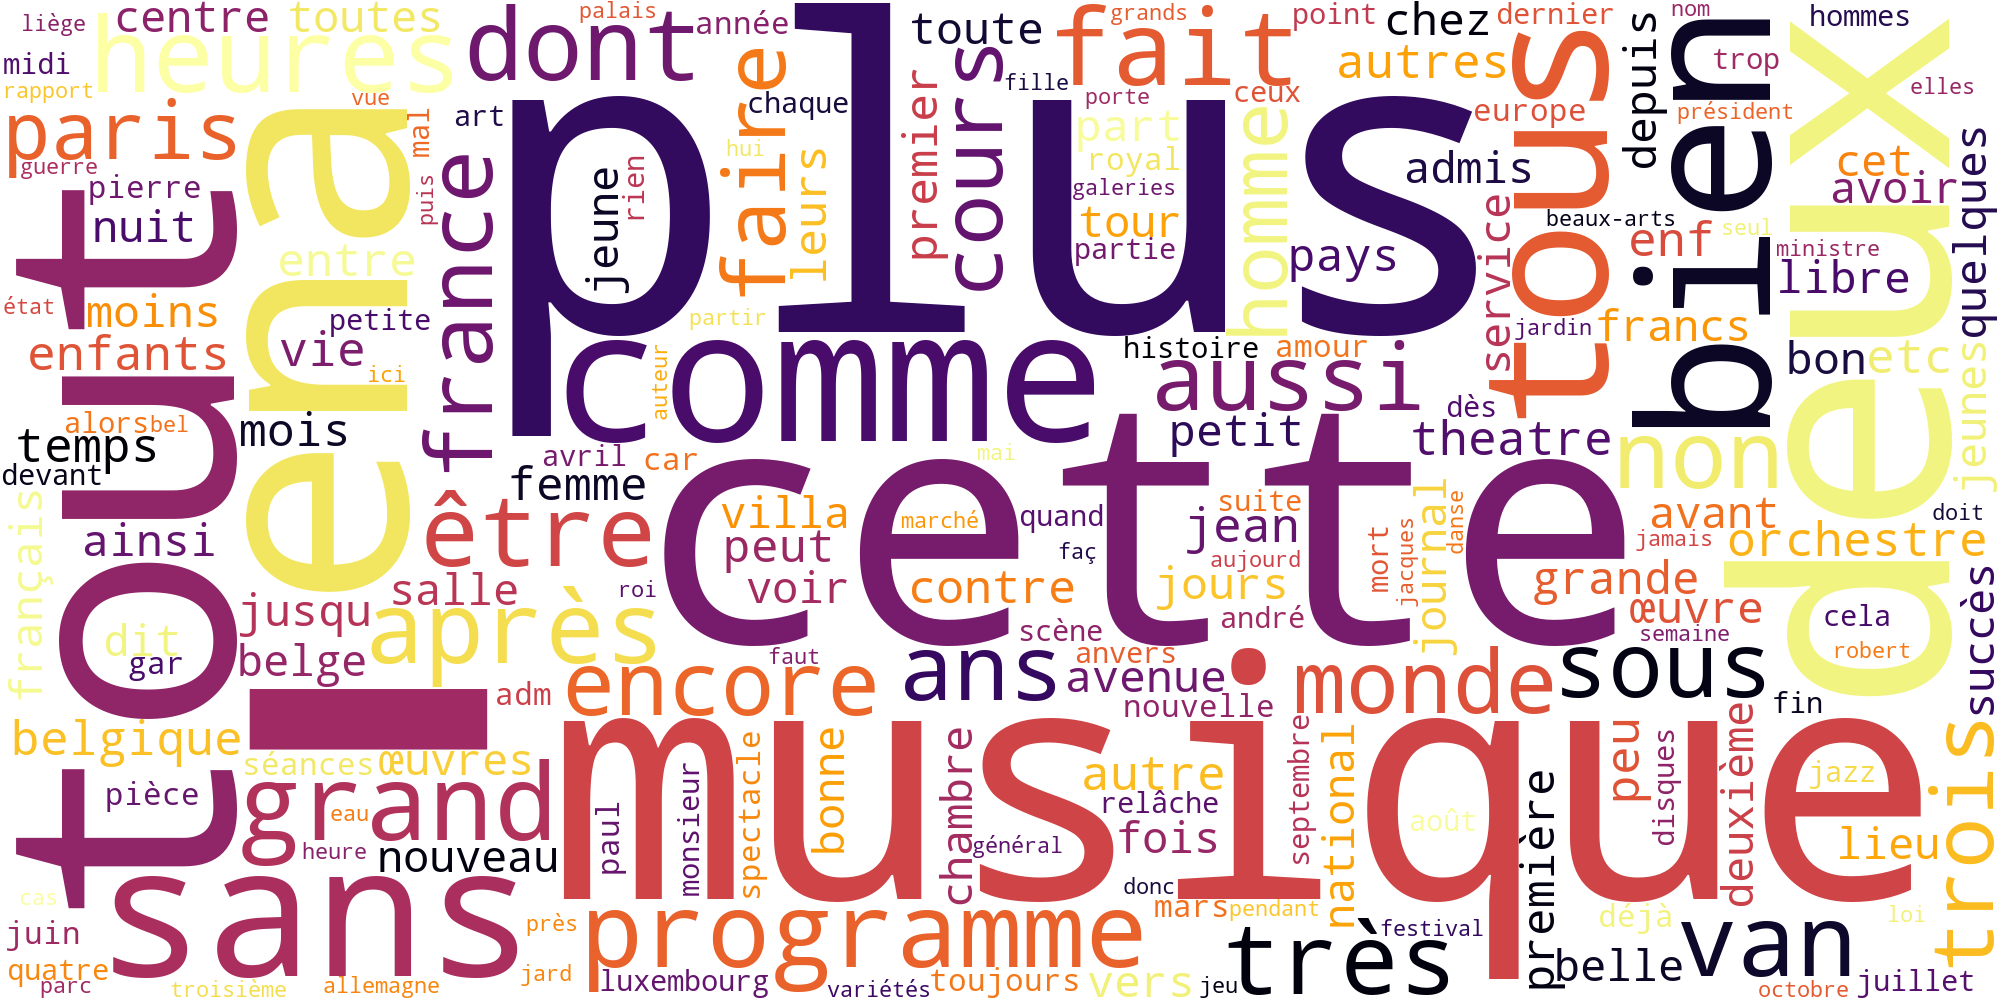

In [56]:
cloud = WordCloud(
    width=2000, height=1000,
    background_color='white',
    colormap='inferno'
).generate_from_frequencies(frequencies)

cloud.to_file("nuage_sorcieres.png")

from IPython.display import Image
Image("nuage_sorcieres.png")
